# **Análisis de figuras geométricas**

**Computación visual**

Gabriela Gallegos Rubio

In [89]:
pip install opencv-python matplotlib numpy  # Se necesita realizar la instalación

In [90]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os

## **Imágen Binarizada**

In [91]:
if not os.path.exists('imagen.png'):
    # Crear una imagen en blanco y negro (800x800)
    img = np.full((800, 800), 190, dtype=np.uint8)

    shadow_layer = np.full((800, 800), 190, dtype=np.uint8)

    # 1. Círculo (ajustado al centroide)
    cv2.circle(shadow_layer, (353, 258), 150, 100, -1)  # Gris más oscuro para sombra
    shadow_layer = cv2.GaussianBlur(shadow_layer, (21, 21), 10)  # Desenfoque para suavidad
    cv2.circle(img, (353, 258), 150, 255, -1)  # Relleno blanco
    cv2.circle(img, (353, 258), 150, 0, 5)     # Contorno negro grueso

    # Sombra del cuadrado
    cv2.rectangle(shadow_layer, (150, 450), (450, 750), 150, -1)  # Sombra gris
    shadow_layer = cv2.GaussianBlur(shadow_layer, (15, 15), 5)  # Desenfoque ligero
    # Cuadrado principal (300x300 píxeles, lados iguales)
    cv2.rectangle(img, (150, 450), (450, 750), 255, -1)  # Relleno blanco
    cv2.rectangle(img, (150, 450), (450, 750), 0, 5)     # Contorno negro grueso

    # 3. Triángulo (parte inferior derecha, con sombreado)
    # Sombra del triángulo
    triangle_pts = np.array([
        [650, 450],  # Vértice superior
        [500, 750],  # Vértice inferior izquierdo
        [800, 750]   # Vértice inferior derecho
    ], np.int32)
    triangle_pts = triangle_pts.reshape((-1, 1, 2))
    cv2.fillPoly(shadow_layer, [triangle_pts], 100)  # Sombra gris
    shadow_layer = cv2.GaussianBlur(shadow_layer, (21, 21), 10)  # Desenfoque
    # Triángulo principal
    cv2.fillPoly(img, [triangle_pts], 255)  # Relleno blanco
    cv2.polylines(img, [triangle_pts], True, 0, 5)  # Contorno negro grueso

    # Combinar la capa de sombreado con la imagen principal
    img = np.minimum(img, shadow_layer)

    cv2.imwrite('imagenFinal.png', img)

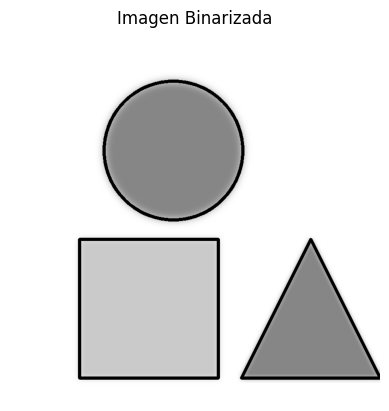

In [92]:
img = cv2.imread('imagenFinal.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title('Imagen Binarizada')
plt.axis('off')
plt.show()

In [93]:
# 1. Preprocesamiento: filtrado + binarización

_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

# 2. Buscar contornos sobre la imagen binaria
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Lista de frames para animación
gif_frames = []

# 3. Dibujar contornos
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
img_contornos = img_color.copy()
cv2.drawContours(img_contornos, contours, -1, (0, 255, 0), 2)
gif_frames.append(img_contornos.copy())

# 4. Calcular métricas
img_metricas = img_contornos.copy()

for cnt in contours:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    M = cv2.moments(cnt)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        cx, cy = 0, 0

    cv2.circle(img_metricas, (cx, cy), 5, (255, 0, 0), -1)
    cv2.putText(img_metricas, f'Area: {area:.0f}', (cx-50, cy-30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    cv2.putText(img_metricas, f'Per: {perimeter:.1f}', (cx-50, cy-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    cv2.putText(img_metricas, f'Centro: ({cx}, {cy})', (cx-50, cy+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

gif_frames.append(img_metricas.copy())

## **Clasificación de figuras**

In [94]:
# 5. Clasificación de figuras
img_final = img_metricas.copy()
for cnt in contours:
    M = cv2.moments(cnt)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        cx, cy = 0, 0

    approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
    num_vertices = len(approx)

    shape = "Desconocido"
    if num_vertices == 3:
        shape = "Triangulo"
    elif num_vertices == 4:
        # Determinar si cuadrado o rectángulo midiendo lados
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h
        shape = "Cuadrado" if 0.95 <= aspect_ratio <= 1.05 else "Rectángulo"
    elif num_vertices == 5:
        shape = "Pentagono"
    elif num_vertices == 6:
        shape = "Hexagono"
    else:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        if perimeter != 0:
            circularity = 4 * np.pi * (area / (perimeter * perimeter))
            if circularity > 0.75:
                shape = "Circulo"

    cv2.putText(img_final, shape, (cx - 50, cy + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

gif_frames.append(img_final.copy())

## **Resultado final**

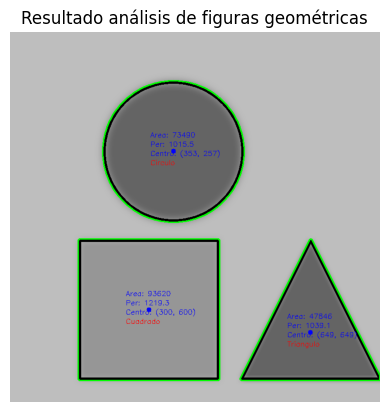

In [95]:
plt.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
plt.axis('off')
#plt.figure(figsize=(12, 12))
plt.title('Resultado análisis de figuras geométricas')
plt.show()

# Guardar animación GIF
with imageio.get_writer('animacion.gif', mode='I', duration=1000) as writer:
    for frame in gif_frames:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        writer.append_data(frame_rgb)